Run the first two cells on command line. Does not run on jupyter notebook.
<br>
Checking the basic statistics of the NCBI disease corpus and the MEDIC dictionary.

In [3]:
# Setting stuff up

import logging
import logging.config

import configparser as cp
import args

import numpy as np
from keras.preprocessing.sequence import pad_sequences
import pickle
import random
import nltk
import time
import os

import vectorizer
import load
import sample

#configurations
dynamic_defaults = {'timestamp': time.strftime('%Y%m%d-%H%M%S')}
config = cp.ConfigParser(defaults=dynamic_defaults,interpolation=cp.ExtendedInterpolation(),strict=False)
try:
    directory = os.path.join(os.path.abspath(os.path.dirname(__file__)))
    config.read(os.path.join(directory, 'defaults.cfg'))
except NameError:
    directory = '/home/lhchan/disease_normalization/src'
    config.read(os.path.join(directory, 'defaults.cfg'))
    

#argparser
args = args.get_args()
'''
>>> args.train
False
'''

#logging
logger = logging.getLogger(__name__)
logging.config.dictConfig({
    'version': 1,
    'disable_existing_loggers': False,
    'formatters': {
        'standard': {
            'format': '%(asctime)s [%(levelname)s] %(name)s: %(message)s'
        },
    },
    'handlers': {
        'default': {
            'level':'INFO',
            'formatter': 'standard',
            'class':'logging.StreamHandler',
        },
    },
    'loggers': {
        '': {
            'handlers': ['default'],
            'level': 'INFO',
            'propagate': True
        }
    }
})


# word embedding
vector_model, vocabulary, inversed_vocabulary = vectorizer.prepare_embedding_vocab(config['embedding']['emb_file'], binary = True, limit = config.getint('embedding','limit'))
# vector_model, vocabulary, inversed_vocabulary = vectorizer.prepare_embedding_vocab('/home/lenz/disease-normalization/data/embeddings/wvec_50_haodi-li-et-al.bin', binary = True, limit = 1000000)
pretrained = vectorizer.load_pretrained_word_embeddings(vocabulary, vector_model)

# MEDIC dictionary
dictionary = load.Terminology()
# dictionary of entries, key = canonical id, value = named tuple in the form of
#   MEDIC_ENTRY(DiseaseID='MESH:D005671', DiseaseName='Fused Teeth',
#   AllDiseaseIDs=('MESH:D005671',), AllNames=('Fused Teeth', 'Teeth, Fused')
dictionary.loaded = load.load(config['terminology']['dict_file'],'MEDIC')


def concept_obj(conf,dictionary,order=None):
    # concept_ids = [] # list of all concept ids
    # concept_all_ids = [] # list of (lists of all concept ids with alt IDs)
    concept_names = [] # list of all names, same length as concept_ids
    # concept_map = {} # names as keys, ids as concepts


    if order:
        use = order
        logger.info('Re-initializng concept object.')
    else:
        use = dictionary.loaded.keys()

    for k in use:
    # keys not in congruent order! To make them congruent:
    # k,v = zip(*dictionary.loaded.items())
    # k = list(k)
    # k.sort()
        # c_id = dictionary.loaded[k].DiseaseID
        # a_ids = dictionary.loaded[k].AllDiseaseIDs
        for n in dictionary.loaded[k].AllNames:
            concept_names.append(n)

    # tokenization & vectorization of dictionary terms
    import nltk

    # save the stuff to object
    concept = sample.NewDataSet('concepts')
    #concept.ids = concept_ids
    #concept.all_ids = concept_all_ids
    concept.names = concept_names
    #concept.map = concept_map
    concept.tokenize = [nltk.word_tokenize(name) for name in concept.names] # list of list of tokenized names
    concept.vectorize = np.array([[vocabulary.get(text.lower(),1) for text in concept] for concept in concept.tokenize])
    concept.padded = pad_sequences(concept.vectorize, padding='post', maxlen=int(config['embedding']['length']))

    return concept

concept = concept_obj(config,dictionary)

usage: ipykernel_launcher.py [-h] [-t]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/1016/jupyter/kernel-f3f25071-4802-4d5e-9fc8-27a18c96e6a7.json


SystemExit: 2

/home/lhchan/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
corpus_train = sample.NewDataSet('training corpus')
corpus_train.objects = load.load(config['corpus']['training_file'],'NCBI')

corpus_dev = sample.NewDataSet('dev corpus')
corpus_dev.objects = load.load(config['corpus']['development_file'],'NCBI')

corpus_test = sample.NewDataSet('test corpus')
corpus_test.objects = load.load('/home/lhchan/disease_normalization/data/NCBItestset_corpus.txt','NCBI')


for corpus in [corpus_train, corpus_dev, corpus_test]:
    mention_ids = [] # list of all ids (gold standard for each mention)
    mention_names = [] # list of all names
    mention_all = [] # list of tuples (mention_text,gold,context,(start,end,docid))

    #sth wrong here that sometimes throw an error
    #import pdb;pdb.set_trace()
    for abstract in corpus.objects:
        for section in abstract.sections: # title and abstract
            for mention in section.mentions:
                nor_ids = [sample._nor_id(one_id) for one_id in mention.id]
                mention_ids.append(nor_ids) # append list of ids, usually len(list)=1
                mention_names.append(mention.text)
                mention_all.append((mention.text,nor_ids,section.text,(mention.start,mention.end,abstract.docid)))

    # tokenization & vectorization of mentions
    import nltk
    mention_tokenize = [nltk.word_tokenize(name) for name in mention_names]
    mention_vectorize = np.array([[vocabulary.get(text.lower(),1) for text in mention] for mention in mention_tokenize])


    corpus.ids = mention_ids
    corpus.names = mention_names
    corpus.all = mention_all
    corpus.tokenize = mention_tokenize
    corpus.vectorize = mention_vectorize

# padding
for corpus in [corpus_train, corpus_dev, corpus_test]:
    logger.info('Padding {0}'.format(corpus.info))
    logger.info('Old shape: {0}'.format(corpus.vectorize.shape))
    corpus.padded = pad_sequences(corpus.vectorize, padding='post', maxlen=int(config['embedding']['length']))
    #format of corpus.padded: numpy, mentions, padded

NameError: name 'vocabulary' is not defined

In [4]:
# load data from command line
import pickle
[concept,corpus_train,corpus_dev,corpus_test] = pickle.load(open('gitig_delme.pickle','rb'))

print(len(concept.names))
print(len(corpus_train.names))
print(len(corpus_dev.names))
print(len(corpus_test.names))

67782
5145
787
960


In [5]:
token_lengths_vocab = [len(e) for e in concept.tokenize]
token_lengths_train = [len(e) for e in corpus_train.tokenize]
token_lengths_dev = [len(e) for e in corpus_dev.tokenize]
token_lengths_test = [len(e) for e in corpus_test.tokenize]

print(max(token_lengths_vocab))
print(max(token_lengths_train))
print(max(token_lengths_dev))
print(max(token_lengths_test))

33
16
10
11


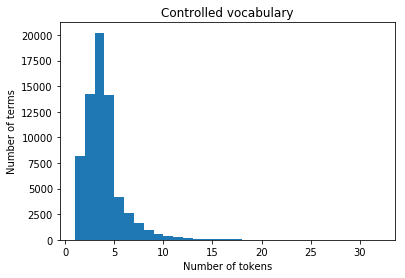

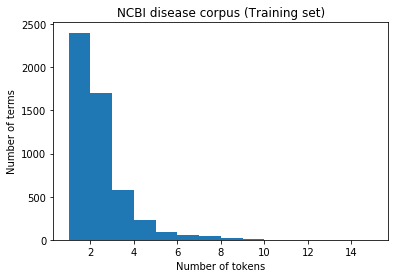

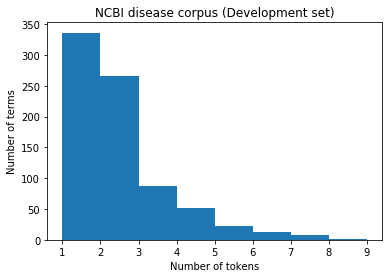

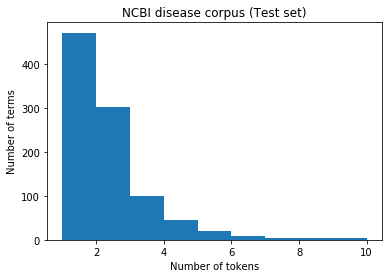

In [6]:
%matplotlib inline

# 'Distribution of length of tokenized mentions'

import numpy as np
import matplotlib.pyplot as plt

def plot_dist(length_lst, title):
    n, bins, patches = plt.hist(length_lst,bins=np.arange(np.min(length_lst),np.max(length_lst),1))
    plt.title(title)
    plt.xlabel('Number of tokens')
    plt.ylabel('Number of terms')
    plt.show()
    
plot_dist(token_lengths_vocab,'Controlled vocabulary')
plot_dist(token_lengths_train,'NCBI disease corpus (Training set)')
plot_dist(token_lengths_dev,'NCBI disease corpus (Development set)')
plot_dist(token_lengths_test,'NCBI disease corpus (Test set)')

In [7]:
# percentage of terms with more than 10 tokens

def coverage(n,lst):
    count=0
    for length in lst:
        if length >n:
            count += 1
    p = 1-(count/float(len(lst)))
    print('Percentage of terms covered {0}'.format(p))

coverage(10,token_lengths_vocab)
coverage(10,token_lengths_train)
coverage(10,token_lengths_dev)
coverage(10,token_lengths_test)

Percentage of terms covered 0.9878433802484435
Percentage of terms covered 0.998639455782313
Percentage of terms covered 1.0
Percentage of terms covered 0.9989583333333333
